# Scrapping

In [5]:
# import module
import requests
from bs4 import BeautifulSoup
import pandas as pd
  
HEADERS = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
            AppleWebKit/537.36 (KHTML, like Gecko) \
            Chrome/90.0.4430.212 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})
  
# user define function
# Scrape the data
def getdata(url):
    r = requests.get(url, headers=HEADERS)
    return r.text
  
def html_code(url):
  
    # pass the url
    # into getdata function
    htmldata = getdata(url)
    soup = BeautifulSoup(htmldata, 'html.parser')
  
    # display html code
    return (soup)

In [8]:
# download all pages
url = []
a = "https://www.tripadvisor.com/Attraction_Review-g226865-d189258-Reviews-or"
b = "-Disneyland_Paris-Marne_la_Vallee_Seine_et_Marne_Ile_de_France.html"

# Anaheim : 23,578 reviews
# HongKong: 12,325 reviews
# Tokyo : 3,241 reviews
# Paris : 18,039 reviews

for i in range(10,18000,10):
    url.append(a+str(i)+b)

soup = []
for x in url:
    soup.append(html_code(x))

In [ ]:
# Title/Review
title_final =[]
review_final = []
for i in range(len(soup)):
        reviews = []
        for j in soup[i].find_all("span", class_="NejBf"):
                reviews.append(j.get_text())
        review = reviews[1::2]
        title = reviews[0::2]
        title_final = title_final + title
        review_final = review_final + review

# Date
date_final = []
for i in range(len(soup)):
        date = []
        for j in soup[i].find_all("div", class_="WlYyy diXIH cspKb bQCoY"):
                date.append(j.get_text())
        date_final = date_final + date

# Rating
rating_final = []
for i in range(len(soup)):
        tag = soup[i].find_all("svg")
        rating =[]
        for j in tag:
                rating.append(j.get('aria-label'))
        rating = [x for x in rating if x]
        rating.pop(0)
        rating_final = rating_final + rating

print(len(title_final))
print(len(review_final))
print(len(date_final))
print(len(rating_final))

In [6]:
# make dataframe
review_final = pd.DataFrame(review_final)
review_final.rename({0:"review"}, axis=1, inplace=True)
title_final = pd.DataFrame(title_final)
title_final.rename({0:"title"}, axis=1, inplace=True)
date_final = pd.DataFrame(date_final)
date_final.rename({0:"date"}, axis=1, inplace=True)
rating_final = pd.DataFrame(rating_final)
rating_final.rename({0:"rating"}, axis=1, inplace=True)
    
frames = [title_final, review_final, rating_final, date_final]
df = pd.concat(frames, axis=1)
df

In [ ]:
# delete duplicates
df = df.drop_duplicates(subset=['title','review'], keep='first', inplace=False, ignore_index=False)
df

In [ ]:
# save to csv
df.to_csv('reviews_jp.csv', index=False)

In [ ]:
# check & delete errors
rating_final[rating_final[0] == 11]

# EDA

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from matplotlib import pyplot as plt

In [2]:
cali_df = pd.read_csv("cali_df.csv")
hk_df = pd.read_csv("reviews_hk.csv")
jap_df = pd.read_csv("reviews_jp.csv")

jap_df['name'] = 'japan'
cali_df['name'] = 'cali'
hk_df['name'] = 'hk'

def clean(df):
    df['rating'] = df['rating'].astype(str).str[0]
    df['rating'] = df['rating'].astype(int)
    date = df['date'].str.split(' ', n=1, expand = True)
    df['date'] = date[1]
    day = df['date']
    date = [datetime.strptime(x, '%B %d, %Y') for x in day]
    df['date'] = date
    return df

jap_df = clean(jap_df)
#cali_df = clean(cali_df)
hongk_df = clean(hk_df)

import re
def review_cleaning(text): 
    text = text.str.replace(r'[^a-z0-9A-Z_]', ' ', regex=True)
    text = text.str.lower()
    text = text.str.replace(r'\d+', '', regex=True)
    text = text.str.replace(r"\W", ' ', regex=True)
    text = text.str.replace(r"[^a-zA-Z0-9]+", ' ', regex=True)
    return text

jap_df['review'] = review_cleaning(jap_df['review'])
#cali_df['Review'] = review_cleaning(cali_df['Review'])
hk_df['review'] = review_cleaning(hk_df['review'])

hk_df.rename({"title":"Header", "review":"Review", "rating":"Rating", "date":"Date"}, axis=1, inplace=True)
jap_df.rename({"title":"Header", "review":"Review", "rating":"Rating", "date":"Date"}, axis=1, inplace=True)

jap_df['Header'] = review_cleaning(jap_df['Header'])
cali_df['Header'] = review_cleaning(cali_df['Header'])
hk_df['Header'] = review_cleaning(hk_df['Header'])

df_all = pd.concat([hk_df,jap_df,cali_df])
df_all = df_all.reset_index(drop=True)
df_all = df_all.drop_duplicates(subset=['Header','Review'], keep='first', inplace=False, ignore_index=False)
df_all["sentiment"] = np.where((df_all.Rating == 5) | (df_all.Rating == 4), "Positive","")
df_all["sentiment"] = np.where((df_all.Rating == 1) | (df_all.Rating == 2) | (df_all.Rating == 3), "Negative",df_all["sentiment"])
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all["Month"] = df_all['Date'].dt.month
df_all["Year"] = df_all['Date'].dt.year
df_all["Season"] = "Winter"
df_all["Season"] = np.where((df_all["Month"]==9)|(df_all["Month"]==10)|(df_all["Month"]==11), "Fall", df_all.Season)
df_all["Season"] = np.where((df_all["Month"]==6)|(df_all["Month"]==7)|(df_all["Month"]==8), "Summer", df_all.Season)
df_all["Season"] = np.where((df_all["Month"]==3)|(df_all["Month"]==4)|(df_all["Month"]==5), "Spring", df_all.Season)
df_all

,Header,Review,Rating,Date,name,sentiment,Month,Year,Season
0,a disney christmas indulge in disney s festive...,christmas is right around the corner and noth...,4,2021-12-30,hk,Positive,12,2021,Winter
1,disappointed,it wss christmas day but most of the outdoor s...,1,2021-12-27,hk,Negative,12,2021,Winter
2,disappointing terrible unbelievable even for r...,i guess there s no control on the limit of the...,1,2021-12-26,hk,Negative,12,2021,Winter
3,not a magical day,wifi and network are not stable ticketing and ...,2,2021-12-26,hk,Negative,12,2021,Winter
4,very long queuing time terrible experience,unacceptable queueing time not only for the ga...,1,2021-12-23,hk,Negative,12,2021,Winter
...,...,...,...,...,...,...,...,...,...
20874,like a big comfort blanket,i have just returned from a family holiday to ...,5,2017-04-21,cali,Positive,4,2017,Spring
20875,enchanting experience,the last time we visited disneyland was a few ...,5,2017-04-20,cali,Positive,4,2017,Spring
20876,a magical day at disneyland,this was our rd trip to disneyland and every t...,5,2017-04-20,cali,Positive,4,2017,Spring
20877,dance tour,disney was as magical as ever and did not disa...,5,2017-04-20,cali,Positive,4,2017,Spring


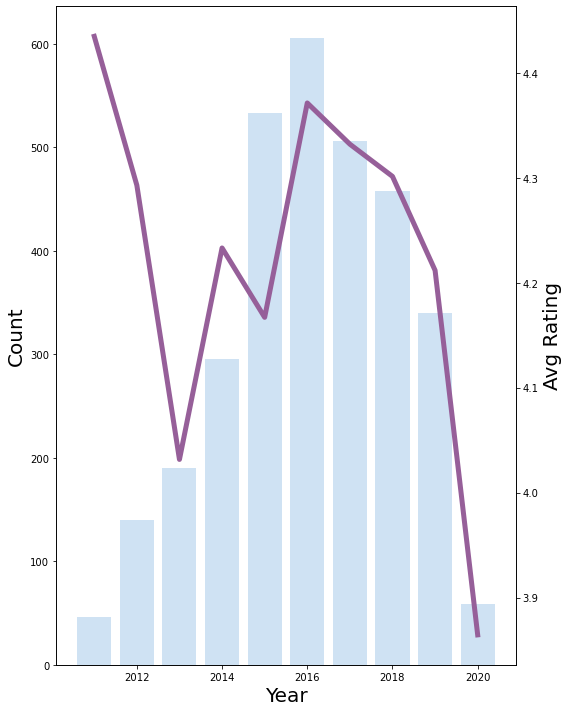

In [3]:
jp_count = pd.DataFrame(df_all[df_all.name == "japan"].groupby("Year").Rating.count())
jp_count.rename({"Rating":"Count"}, axis=1, inplace=True)
jp_count.drop(jp_count.index[0:6], axis=0, inplace=True)
jp_count.drop(jp_count.index[10], axis=0, inplace=True)

jp_rating = pd.DataFrame(df_all[df_all.name == "japan"].groupby("Year").Rating.mean())
jp_rating.rename({"Rating":"Avg"}, axis=1, inplace=True)
jp_rating.drop(jp_rating.index[0:6], axis=0, inplace=True)
jp_rating.drop(jp_rating.index[10], axis=0, inplace=True)

fig, ax1 = plt.subplots(figsize=(8,10))

color = '#cfe2f3ff' #{"#9cd7d5","#ca8fa5","#8269aa","#965f99"}
ax1.set_xlabel('Year', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
ax1.bar(jp_count.index, jp_count.Count, color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#965f99'
ax2.set_ylabel('Avg Rating', fontsize=20)  # we already handled the x-label with ax1
ax2.plot(jp_count.index, jp_rating.Avg, color=color, linewidth=5)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

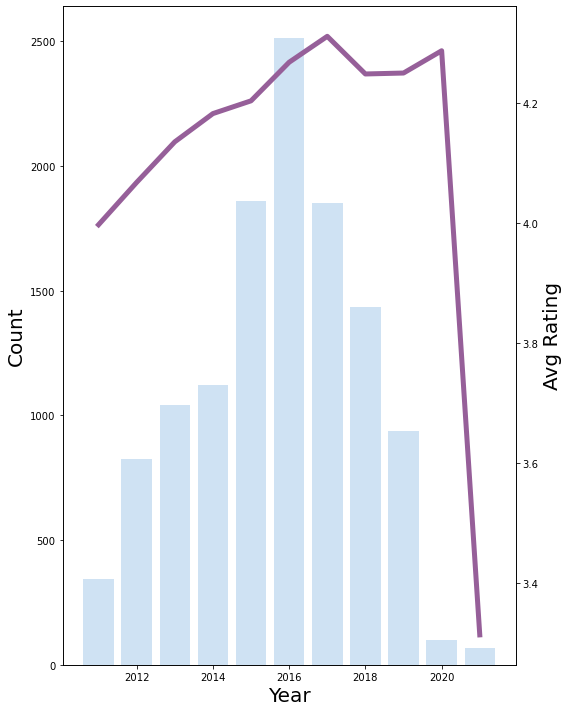

In [4]:
jp_count = pd.DataFrame(df_all[df_all.name == "hk"].groupby("Year").Rating.count())
jp_count.rename({"Rating":"Count"}, axis=1, inplace=True)
jp_count.drop(jp_count.index[0:6], axis=0, inplace=True)

jp_rating = pd.DataFrame(df_all[df_all.name == "hk"].groupby("Year").Rating.mean())
jp_rating.rename({"Rating":"Avg"}, axis=1, inplace=True)
jp_rating.drop(jp_rating.index[0:6], axis=0, inplace=True)

fig, ax1 = plt.subplots(figsize=(8,10))

color = '#cfe2f3ff' #{"#9cd7d5","#ca8fa5","#8269aa","#965f99"}
ax1.set_xlabel('Year', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
ax1.bar(jp_count.index, jp_count.Count, color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#965f99'
ax2.set_ylabel('Avg Rating', fontsize=20)  # we already handled the x-label with ax1
ax2.plot(jp_count.index, jp_rating.Avg, color=color, linewidth=5)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

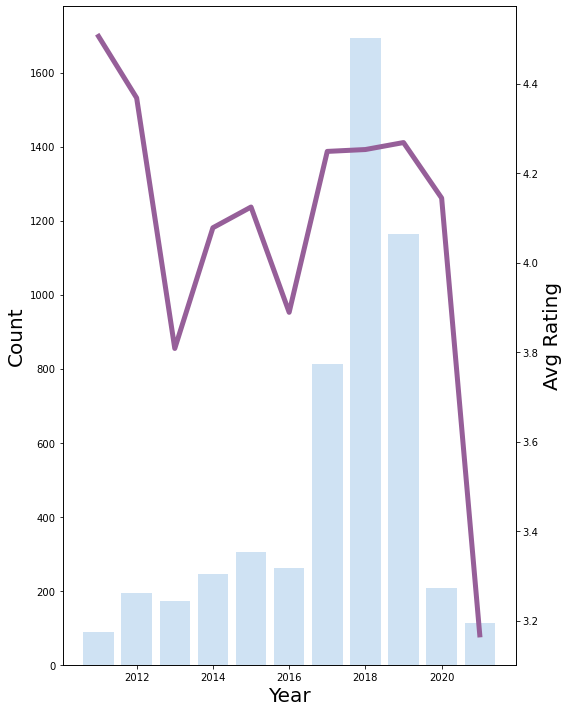

In [5]:
jp_count = pd.DataFrame(df_all[df_all.name == "cali"].groupby("Year").Rating.count())
jp_count.rename({"Rating":"Count"}, axis=1, inplace=True)
jp_count.drop(jp_count.index[0], axis=0, inplace=True)
jp_count.drop(jp_count.index[11], axis=0, inplace=True)

jp_rating = pd.DataFrame(df_all[df_all.name == "cali"].groupby("Year").Rating.mean())
jp_rating.rename({"Rating":"Avg"}, axis=1, inplace=True)
jp_rating.drop(jp_rating.index[0], axis=0, inplace=True)
jp_rating.drop(jp_rating.index[11], axis=0, inplace=True)

fig, ax1 = plt.subplots(figsize=(8,10))

color = '#cfe2f3ff' #{"#9cd7d5","#ca8fa5","#8269aa","#965f99"}
ax1.set_xlabel('Year', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
ax1.bar(jp_count.index, jp_count.Count, color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#965f99'
ax2.set_ylabel('Avg Rating', fontsize=20)  # we already handled the x-label with ax1
ax2.plot(jp_count.index, jp_rating.Avg, color=color, linewidth=5)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [6]:
df_seaon_rating = pd.DataFrame(df_all.groupby("Season").Rating.mean())
df_seaon_rating

,Rating
Season,
Fall,4.218513
Spring,4.191409
Summer,4.205790
Winter,4.214371


In [7]:
ratio_all = pd.DataFrame(df_all.Season.value_counts())
ratio_all.loc['Total'] = ratio_all.sum(numeric_only=True, axis=0)
ratio_all.insert(1, "%", round(ratio_all.iloc[:,0]/ratio_all.iloc[:,0].Total*100,2), True)
ratio_all

,Season,%
Spring,5564,26.66
Summer,5389,25.82
Winter,5038,24.14
Fall,4883,23.39
Total,20874,100.00


In [8]:
season_ratio_df = pd.concat([df_seaon_rating["Rating"],ratio_all["%"]], axis=1)
season_ratio_df.drop(season_ratio_df.index[4], axis=0, inplace=True)

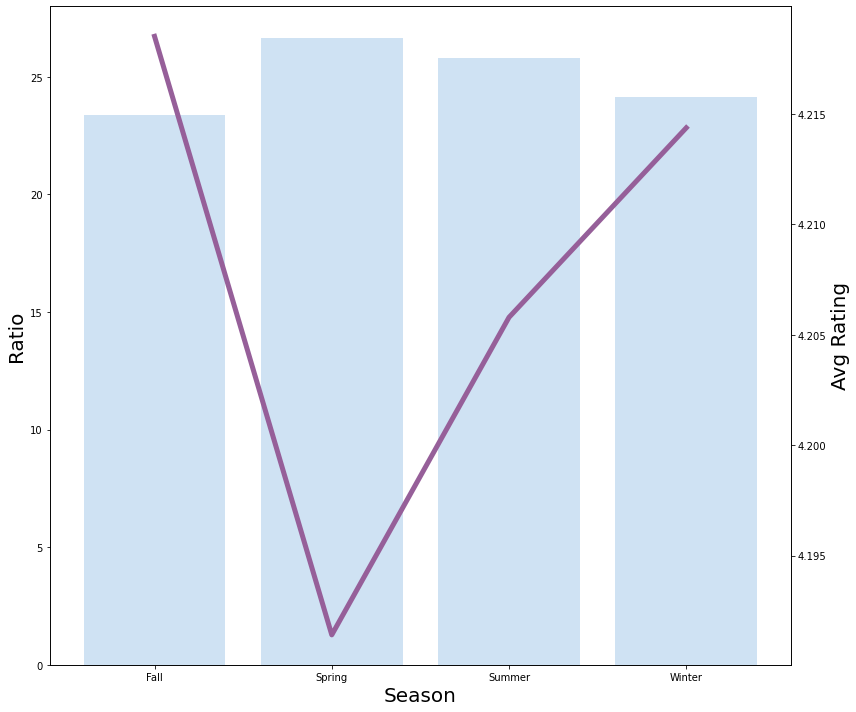

In [9]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = '#cfe2f3ff' #{"#9cd7d5","#ca8fa5","#8269aa","#965f99"}
ax1.set_xlabel('Season', fontsize=20)
ax1.set_ylabel('Ratio', fontsize=20)
ax1.bar(season_ratio_df.index, season_ratio_df["%"], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#965f99'
ax2.set_ylabel('Avg Rating', fontsize=20)  # we already handled the x-label with ax1
ax2.plot(season_ratio_df.index, season_ratio_df.Rating, color=color, linewidth=5)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [20]:
ratio_all = pd.DataFrame(df_all.sentiment.value_counts())
ratio_all.loc['Total'] = ratio_all.sum(numeric_only=True, axis=0)
ratio_all.insert(1, "%", round(ratio_all.iloc[:,0]/ratio_all.iloc[:,0].Total*100,2), True)

ratio_jp = pd.DataFrame(df_all[df_all.name == "japan"].sentiment.value_counts())
ratio_jp.loc['Total'] = ratio_jp.sum(numeric_only=True, axis=0)
ratio_jp.insert(1, "%", round(ratio_jp.iloc[:,0]/ratio_jp.iloc[:,0].Total*100,2), True)

ratio_hk = pd.DataFrame(df_all[df_all.name == "hk"].sentiment.value_counts())
ratio_hk.loc['Total'] = ratio_hk.sum(numeric_only=True, axis=0)
ratio_hk.insert(1, "%", round(ratio_hk.iloc[:,0]/ratio_hk.iloc[:,0].Total*100,2), True)

ratio_cali = pd.DataFrame(df_all[df_all.name == "cali"].sentiment.value_counts())
ratio_cali.loc['Total'] = ratio_cali.sum(numeric_only=True, axis=0)
ratio_cali.insert(1, "%", round(ratio_cali.iloc[:,0]/ratio_cali.iloc[:,0].Total*100,2), True)

ratio_df = pd.concat([ratio_all["%"],ratio_jp["%"],ratio_hk["%"],ratio_cali["%"]], axis=1)

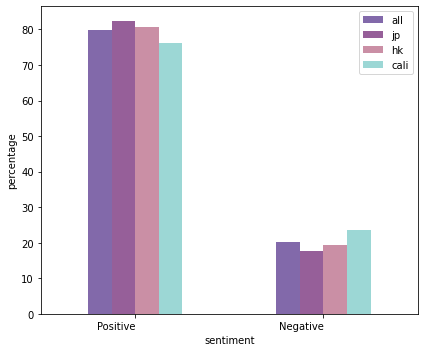

In [21]:
plt.rcParams["figure.figsize"] = [6, 5]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
ratio_df[0:2].plot(ax=ax, kind='bar', xlabel='sentiment', ylabel='percentage', color = {"#9cd7d5","#ca8fa5","#8269aa","#965f99"}
)
plt.legend(['all', 'jp', 'hk', 'cali']);
plt.xticks(rotation=0, ha='right')
plt.show()

# Word Cloud

In [10]:
# Word Cloud Packages

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import FreqDist
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

In [12]:
good_pool = " ".join(review for review in df_all[df_all.sentiment == "Positive"]["Review"])
bad_pool = " ".join(review for review in df_all[df_all.sentiment == "Negative"]["Review"])

stopwords = set(STOPWORDS)
stopwords.update(["will","going"])

In [13]:
mask = np.array(Image.open("castle_color.jpeg"))
mask.shape

(1330, 1500, 3)

In [14]:
stopwords.update(["will","going", "disney", "disneyland", "ride", 'park', "rides", 
"s", "day", "one", "time", "kid", "go", "kids", "u","visit","went", "good", "hong", "kong"
                  ])

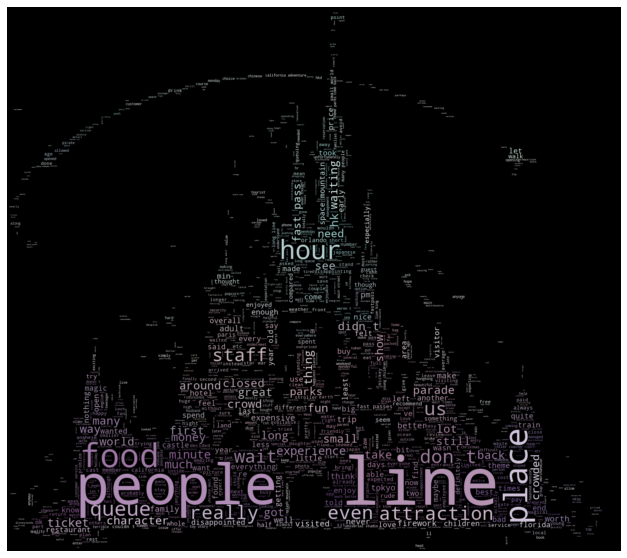

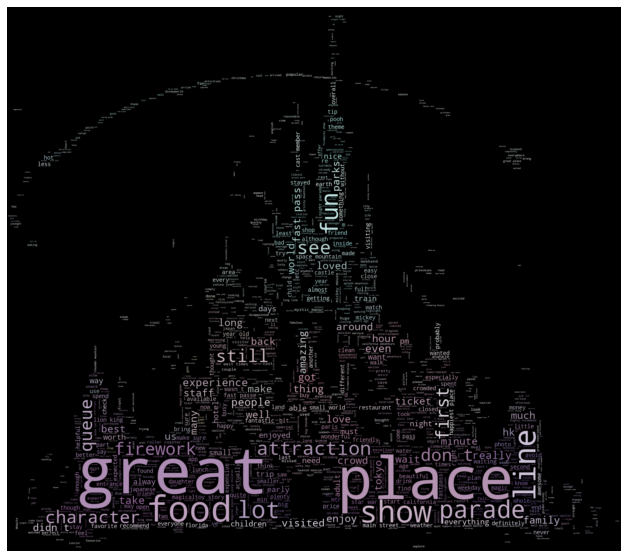

In [15]:
# Create a word cloud image
wc = WordCloud(background_color="black", max_words=1500, mask=mask,
               stopwords=stopwords, contour_width=1, contour_color="black")

# Generate a wordcloud
wc.generate(bad_pool)
image_colors = ImageColorGenerator(np.array(mask))
wc.recolor(color_func=image_colors)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig(f'negative.png',
            dpi = 300)
plt.show()

# Generate a wordcloud
wc.generate(good_pool)
image_colors = ImageColorGenerator(np.array(mask))
wc.recolor(color_func=image_colors)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig(f'positive.png',
            dpi = 300)
plt.show()